In [1]:
import pandas as pd
print(pd.__version__)

2.2.3


In [2]:
import os
import sys
# Add the root directory to Python path
root_dir = "C:\\Users\\Jordan Lankford\\Documents\\GitHub\\FineTune-DQN"
if root_dir not in sys.path:
    sys.path.append(root_dir)

# Now imports should work
from src.utils.utils import set_seeds
import torch
import torch.nn as nn
import gymnasium as gym
import numpy as np
from src.utils.utils import set_seeds
from torchsummary import summary

def encode_state(obs, n_states):
    obs = torch.Tensor(obs)
    return nn.functional.one_hot(obs.long(), n_states).float()

def get_mask(info, n_actions=25):
    allowed_actions = info['admissible_actions']
    mask = np.zeros(n_actions)
    mask[allowed_actions] = 1
    return torch.Tensor(mask).unsqueeze(0)

# Modified QNetwork to match the deep DQN structure
class QNetwork(nn.Module):
    def __init__(self, env):
        super().__init__()
        self.n_states = env.observation_space.n
        self.n_actions = env.action_space.n
        
        # Match the architecture of the deep DQN
        self.network = nn.Sequential(
            nn.Linear(self.n_states, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, self.n_actions)
        )

    def forward(self, x, action_masks=None):
        q_values = self.network(x)
        if action_masks is not None:
            q_values = q_values - ((1 - action_masks) * 1e10)
        return q_values

# Create environment and network
env = gym.make('Sepsis/ICU-Sepsis-v2')
q_network = QNetwork(env)

# Load the trained deep DQN weights
model_path = r"C:\Users\Jordan Lankford\Documents\GitHub\FineTune-DQN\models\dqn\dqn_final_seed_0.pt"
state_dict = torch.load(model_path)

# Print the keys in the state dict to verify structure
print("State dict keys:", state_dict.keys())

# Load the weights
try:
    q_network.load_state_dict(state_dict)
    print("Successfully loaded weights!")
except Exception as e:
    print(f"Error loading weights: {e}")
    # Try loading with strict=False if there are issues
    q_network.load_state_dict(state_dict, strict=False)
    print("Loaded weights with strict=False")

# Print model structure
print("\nModel Architecture:")
print(q_network)


State dict keys: odict_keys(['network.0.weight', 'network.0.bias', 'network.2.weight', 'network.2.bias', 'network.4.weight', 'network.4.bias'])
Successfully loaded weights!

Model Architecture:
QNetwork(
  (network): Sequential(
    (0): Linear(in_features=716, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=25, bias=True)
  )
)


C:\Users\Jordan Lankford\AppData\Local\Temp\ipykernel_25180\2027990685.py:55: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path)


In [3]:
weight_shapes = []
for param in q_network.parameters():
    weight_shapes.append(param.shape)
print(weight_shapes)


[torch.Size([128, 716]), torch.Size([128]), torch.Size([128, 128]), torch.Size([128]), torch.Size([25, 128]), torch.Size([25])]


In [4]:
values_in_dimension=[]
for shape in weight_shapes:
    values_in_dimension.append(np.prod(shape))
print(values_in_dimension)

[np.int64(91648), np.int64(128), np.int64(16384), np.int64(128), np.int64(3200), np.int64(25)]


In [5]:
weights = [param.detach().numpy() for param in q_network.parameters()]  # Get all model weights as numpy arrays


In [7]:
def f(fly, flies_history = None, model=q_network, env=env):
    cloned_model = q_network
    reshaped_fly = reshape_to_model_weights(fly, model)
    cloned_model.load_state_dict(dict(zip([name for name, _ in cloned_model.named_parameters()], reshaped_fly)))
    cloned_model.eval()

    episode_rewards = np.zeros(20000, dtype=np.float32)  # Pre-allocate array
    
    # Pre-allocate tensors
    state_encoded = torch.zeros((1, env.observation_space.n), dtype=torch.float32)
    action_mask = torch.zeros((1, env.action_space.n), dtype=torch.float32)
    
    with torch.no_grad():  # Move no_grad outside the loop
        for episode in range(20000):
            state, info = env.reset()
            episode_reward = 0
            done = False
            
            while not done:
                # Reuse pre-allocated tensors
                state_encoded.zero_()
                state_encoded[0, state] = 1
                
                action_mask.zero_()
                action_mask[0, info['admissible_actions']] = 1
                
                q_values = cloned_model(state_encoded, action_mask)
                action = q_values.argmax(dim=1).item()
                
                state, reward, terminated, truncated, info = env.step(action)
                episode_reward += reward
                done = terminated or truncated

            episode_rewards[episode] = episode_reward

    fitness = float(np.mean(episode_rewards))
    return -f_avrg(fitness, flies_history) if flies_history is not None else -fitness

In [15]:
#run fly through the fitness function 20 times, calculate the range in fitness values

#f(fly, flies_history = None, model=q_network,env=env)
fitness_values = []
for i in range(10):
    fitness_values.append(f(flies[0], flies_history = None, model=q_network,env=env))

print(fitness_values)
#range of fitness values
range_fitness = max(fitness_values) - min(fitness_values)
print(range_fitness)


[-0.8081499934196472, -0.8118000030517578, -0.8121500015258789, -0.8082000017166138, -0.8123999834060669, -0.8109999895095825, -0.807699978351593, -0.8105499744415283, -0.8152499794960022, -0.8167499899864197]
0.00905001163482666


In [17]:
#standard deviation of fitness values
std_fitness = np.std(fitness_values)
print(std_fitness)
#mean of fitness values
mean_fitness = np.mean(fitness_values)
print(mean_fitness)




0.00283799575919716
-0.811394989490509


In [ ]:
for i in range(20):
    #take the firtst ith number of flies and caluculate mean fitness
    mean_fitness = np.mean(fitness_values[:i])
    print("mean when using", i ,"flies:", mean_fitness)

In [ ]:
'''
from parallel_fitness import parallel_fitness, QNetwork
import time 

def f_parallel(fly, model=q_network, num_processes=4):
    """
    Wrapper for parallel fitness evaluation
    """
    reshaped_fly = reshape_to_model_weights(fly, model)
    state_dict = dict(zip([name for name, _ in model.named_parameters()], reshaped_fly))
    return parallel_fitness(state_dict, num_processes=num_processes)


# Compare performance
print("Testing sequential evaluation:")
start = time.perf_counter()
result_seq = f(flies[0])
time_seq = time.perf_counter() - start
print(f"Sequential result: {result_seq}")
print(f"Sequential time: {time_seq:.2f}s")

print("\nTesting parallel evaluation:")
start = time.perf_counter()
result_par = f_parallel(flies[0], num_processes=4)
time_par = time.perf_counter() - start
print(f"Parallel result: {result_par}")
print(f"Parallel time: {time_par:.2f}s")

print(f"\nSpeedup: {time_seq/time_par:.2f}x")'
'''

In [ ]:

'''
from vectorized_fitness import vectorized_fitness, QNetwork
import time

def f_vectorized(fly, model=q_network, num_envs=4):
    """
    Wrapper for vectorized fitness evaluation
    """
    reshaped_fly = reshape_to_model_weights(fly, model)
    state_dict = dict(zip([name for name, _ in model.named_parameters()], reshaped_fly))
    return vectorized_fitness(state_dict, num_envs=num_envs)

# Test code


print("\nTesting vectorized evaluation:")
start = time.perf_counter()
result_vec = f_vectorized(flies[0], num_envs=4)
time_vec = time.perf_counter() - start
print(f"Vectorized result: {result_vec}")
print(f"Vectorized time: {time_vec:.2f}s")


print("Testing sequential evaluation:")
start = time.perf_counter()
result_seq = f(flies[0])
time_seq = time.perf_counter() - start
print(f"Sequential result: {result_seq}")
print(f"Sequential time: {time_seq:.2f}s")

print(f"\nSpeedup: {time_seq/time_vec:.2f}x")'
'''

In [8]:
def reshape_to_model_weights(flattened_fly, model=q_network):
    # List to store reshaped weights
    reshaped_weights = []
    counter = 0  # Counter for elements in fly
    
    # Get the shapes of the model's parameters
    values_in_dimension = [param.numel() for param in model.parameters()]
    weight_shapes = [param.shape for param in model.parameters()]
    
    for i in range(len(values_in_dimension)):
        # Get the flattened weights for this layer
        weight_flat = flattened_fly[counter: counter + values_in_dimension[i]]
        
        # Reshape and convert to torch.Tensor
        reshaped_layer_weights = torch.tensor(weight_flat, dtype=torch.float32).reshape(weight_shapes[i])
        
        # Append the reshaped weight to the list
        reshaped_weights.append(reshaped_layer_weights)
        
        # Move the counter to the next parameter block
        counter += values_in_dimension[i]
    
    return reshaped_weights


In [9]:
def initialize_flies_from_model(number_of_flies, weights, model, inclusive):
    population = []

    if inclusive == False:
        for i in range(number_of_flies):
            fly = []  # This will hold the flattened weights for a single fly
            
            for param in model.parameters():  # Iterate through model parameters (weights and biases)
                # Generate random weights with the same shape as the model's weight matrix
                scalers = np.random.uniform(0.9, 1.1, size=param.shape)
                print(param.shape)  # Print the shape to see what the weights look like
                scaledweights = param.detach().numpy() * scalers  # Multiply the weight values by the scalers
                
                # Flatten the random weights and add them to the fly
                flattened_weights = scaledweights.flatten()
                fly.append(flattened_weights)
            
            # After flattening each layer's weights, flatten the entire fly and add to population
            population.append(np.concatenate(fly))  # Concatenate the list of flattened weight arrays
            
    if inclusive == True:
        for i in range(number_of_flies):
            fly = []  # This will hold the flattened weights for a single fly
            
            for param in model.parameters():  # Iterate through model parameters (weights and biases)
                if i == 0:
                    flattened_weights = param.detach().numpy().flatten()  # Get the flattened weights for the first fly
                    fly.append(flattened_weights)
                else:
                    scalers = np.random.uniform(0.9, 1.1, size=param.shape)
                    print(param.shape)  # Print the shape to see what the weights look like
                    scaledweights = param.detach().numpy() * scalers  # Multiply the weight values by the scalers
                    
                    # Flatten the random weights and add them to the fly
                    flattened_weights = scaledweights.flatten()
                    fly.append(flattened_weights)
                
            # After flattening each layer's weights, flatten the entire fly and add to population
            population.append(np.concatenate(fly))  # Concatenate the list of flattened weight arrays
        
    return population


In [10]:
num_of_flies = 10

flies = initialize_flies_from_model(num_of_flies,weights,q_network,True)



from collections import deque
max_history = 5
flies_history = [deque(maxlen=max_history) for _ in range(num_of_flies)]

torch.Size([128, 716])
torch.Size([128])
torch.Size([128, 128])
torch.Size([128])
torch.Size([25, 128])
torch.Size([25])
torch.Size([128, 716])
torch.Size([128])
torch.Size([128, 128])
torch.Size([128])
torch.Size([25, 128])
torch.Size([25])
torch.Size([128, 716])
torch.Size([128])
torch.Size([128, 128])
torch.Size([128])
torch.Size([25, 128])
torch.Size([25])
torch.Size([128, 716])
torch.Size([128])
torch.Size([128, 128])
torch.Size([128])
torch.Size([25, 128])
torch.Size([25])
torch.Size([128, 716])
torch.Size([128])
torch.Size([128, 128])
torch.Size([128])
torch.Size([25, 128])
torch.Size([25])
torch.Size([128, 716])
torch.Size([128])
torch.Size([128, 128])
torch.Size([128])
torch.Size([25, 128])
torch.Size([25])
torch.Size([128, 716])
torch.Size([128])
torch.Size([128, 128])
torch.Size([128])
torch.Size([25, 128])
torch.Size([25])
torch.Size([128, 716])
torch.Size([128])
torch.Size([128, 128])
torch.Size([128])
torch.Size([25, 128])
torch.Size([25])
torch.Size([128, 716])
torch.Siz

In [11]:
print(flies_history[0])

deque([], maxlen=5)


In [12]:
def f_avrg(fitness, flies_history):

    flies_history.append(fitness)

    print(flies_history)

    return sum(flies_history) / len(flies_history) # mean
    

In [14]:
f(flies[0],flies_history[0])

deque([0.8102499842643738, 0.8100500106811523], maxlen=5)


-0.8101499974727631

In [ ]:
len(flies[0])

In [12]:
N = len(flies)			# POPULATION SIZE
D = len(flies[0])					# DIMENSIONALITY 
#delta = 0.005			# DISTURBANCE THRESHOLD 
maxIterations = 200	# ITERATIONS ALLOWED
sd = np.std(flies[0])		# STANDARD DEVIATION

In [ ]:
#print the min and max values and the range of the initial population
min_value = np.min(flies[0])
max_value = np.max(flies[0])
range_value = max_value - min_value
print("Initial Population:")
print("Min:", min_value)
print("Max:", max_value)
print("Range:", range_value)
sd = np.std(flies[0])
print("Standard Deviation:", sd)
median = np.median(flies[0])
print("Median:", median)




In [13]:
import numpy as np

def disturbance_threashold_mechanism(delta, counter, patience):
    if delta == 1 and counter > patience:
        return 0, 0 #delta, counter
    elif delta != 1 and counter > patience:
        delta = (delta + np.random.uniform(high=0.5)) #add rand number between 0-0.5
        if delta > 1:
            return 1, 0
        else:
            return delta, 0
    else:
        return delta, counter

In [14]:
fitness_history=[]
delta_history=[]

In [15]:
def DFO(start_flies):
    """
    DFO with initial history population phase and dynamic delta control
    """
    X = np.array(start_flies)     
    fitness = np.zeros(N)         
    flies_history = [deque(maxlen=5) for _ in range(N)]
    counter = 0
    #fitness_history = []
    #delta_history = []
    delta = 1  # Start with maximum exploration

    # First phase: Populate histories for all flies
    print("Populating initial histories...")
    for _ in range(max_history):  # Run evaluations to fill histories
        for i in range(N):
            fitness[i] = f(X[i], flies_history[i])
            print(f"Fly {i} history: {list(flies_history[i])}")
    
    # Now all flies have full histories, start optimization
    s = np.argmin(fitness)
    print(f"\nStarting optimization with best fly: {s}, fitness: {fitness[s]:.3f}")
    
    # Main DFO loop
    for itr in range(maxIterations):
        # Recalculate best fly's fitness
        best_fly_fitness = f(X[s], flies_history[s])
        fitness[s] = best_fly_fitness

        # Find new best fly
        new_s = np.argmin(fitness)
        
        # Update delta using disturbance threshold mechanism
        if itr != 0:
            if fitness[new_s] >= fitness[s]:
                counter += 1
                delta, counter = disturbance_threashold_mechanism(delta, counter, patience=10)
            if fitness[new_s] < fitness[s]:
                counter = 0
            s = new_s

        fitness_history.append(fitness[s])
        delta_history.append(delta)
        
        print(f"\nIteration: {itr}")
        print(f"Best fly {s} recalculated fitness: {fitness[s]:.3f}")
        print(f"Current delta: {delta:.6f}")
        print(f"Counter: {counter}")
        print(f"Best fly history: {list(flies_history[s])}")

        for i in range(N):
            if i == s:
                continue

            left = (i-1) % N
            right = (i+1) % N
            bNeighbour = right if fitness[right] < fitness[left] else left

            old_position = X[i].copy()
            old_fitness = fitness[i]

            # Update each dimension separately
            for d in range(D):
                if np.random.rand() < delta:
                    X[i][d] = np.random.normal(loc=X[bNeighbour][d], scale=delta)
                else:
                    u = np.random.rand()
                    X[i][d] = X[bNeighbour][d] + u * (X[s][d] - X[bNeighbour][d])

            new_fitness = f(X[i], flies_history[i])
            
            if new_fitness < old_fitness:
                fitness[i] = new_fitness
                if new_fitness < fitness[s]:
                    s = i
                    print(f"New best found! Fly {i}: {new_fitness:.3f}")
                    print(f"New best history: {list(flies_history[i])}")
            else:
                X[i] = old_position
                fitness[i] = old_fitness

        # After all flies updated, recheck who is best
        new_s = np.argmin(fitness)
        if new_s <= s:
            counter += 1
            delta, counter = disturbance_threashold_mechanism(delta, counter, patience=1)
        s = new_s
        
        print(f"End of iteration best fly: {s} with fitness: {fitness[s]:.3f}")
        print(f"Best fly history: {list(flies_history[s])}")

    return X[s], fitness_history, delta_history

In [16]:
newweihgts = DFO(flies)


Populating initial histories...
deque([np.float64(0.6666666666666666)], maxlen=5)
Fly 0 history: [np.float64(0.6666666666666666)]
deque([np.float64(1.0)], maxlen=5)
Fly 1 history: [np.float64(1.0)]
deque([np.float64(1.0)], maxlen=5)
Fly 2 history: [np.float64(1.0)]
deque([np.float64(1.0)], maxlen=5)
Fly 3 history: [np.float64(1.0)]
deque([np.float64(0.6666666666666666)], maxlen=5)
Fly 4 history: [np.float64(0.6666666666666666)]
deque([np.float64(1.0)], maxlen=5)
Fly 5 history: [np.float64(1.0)]
deque([np.float64(0.6666666666666666)], maxlen=5)
Fly 6 history: [np.float64(0.6666666666666666)]
deque([np.float64(1.0)], maxlen=5)
Fly 7 history: [np.float64(1.0)]
deque([np.float64(1.0)], maxlen=5)
Fly 8 history: [np.float64(1.0)]
deque([np.float64(0.0)], maxlen=5)
Fly 9 history: [np.float64(0.0)]
deque([np.float64(0.6666666666666666), np.float64(0.3333333333333333)], maxlen=5)
Fly 0 history: [np.float64(0.6666666666666666), np.float64(0.3333333333333333)]
deque([np.float64(1.0), np.float64(0

In [ ]:
np.save('realbest_fly_weights.npy', newweihgts)

In [ ]:
newweihgts = np.load('realbest_fly_weights.npy')

In [ ]:
#Saving fine tuned weights

cloned_model = q_network
    # Reshape fly's weights to match the model's weight shape
reshaped_fly = reshape_to_model_weights(newweihgts)
    
    # Load the reshaped weights into the cloned model
cloned_model.load_state_dict(dict(zip([name for name, _ in cloned_model.named_parameters()], reshaped_fly)))


# save the model as dfoFineTuned
torch.save(cloned_model.state_dict(), 'dfoFineTuned.pt')


In [61]:
len(fitness_history)

43

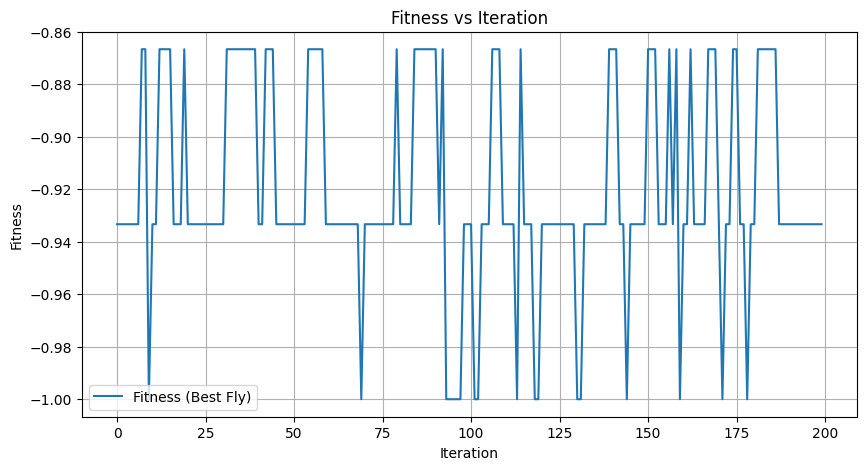

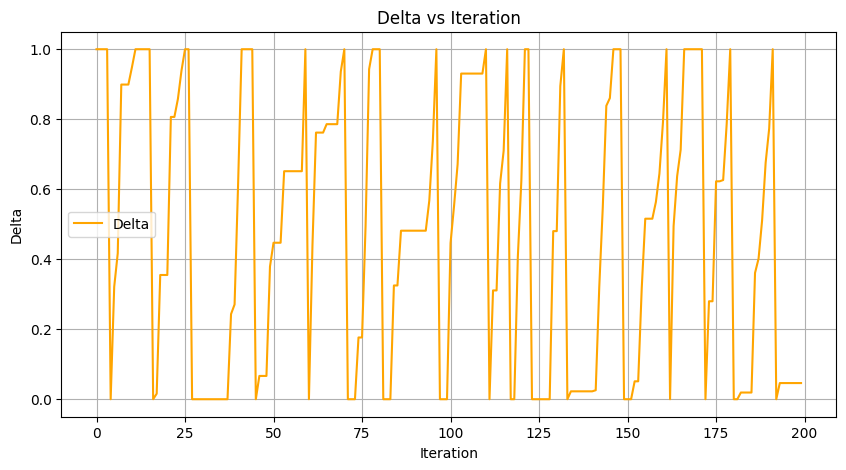

In [17]:
# Plot results after all iterations
import matplotlib.pyplot as plt

# Plot fitness[s]
plt.figure(figsize=(10, 5))
plt.plot(fitness_history, label="Fitness (Best Fly)")
plt.xlabel("Iteration")
plt.ylabel("Fitness")
plt.title("Fitness vs Iteration")
plt.legend()
plt.grid()

# Plot delta
plt.figure(figsize=(10, 5))
plt.plot(delta_history, label="Delta", color='orange')
plt.xlabel("Iteration")
plt.ylabel("Delta")
plt.title("Delta vs Iteration")
plt.legend()
plt.grid()

plt.show()